# Clasificación binaria con sensorial features
Exploración de arquitecturas de redes neuronales para clasificación YES/NO usando `sensorial_features_normalized`.

**Salidas generadas:**
- {GROUP_ID}_{MODEL_ID}_probs_dev.json — probabilidades en dev (para el ensamble)
- {GROUP_ID}_{MODEL_ID}_probs_test.json — probabilidades en test (para el ensamble)
- {GROUP_ID}_{MODEL_ID}.json — predicciones finales de submission
- {GROUP_ID}_{MODEL_ID}_model.pt — pesos del mejor modelo

In [1]:
import os, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support, classification_report, precision_recall_curve

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Configuración

In [2]:
TRAIN_JSON      = '../preprocessed_data/train_split.json'
DEV_JSON        = '../preprocessed_data/dev_split.json'
TEST_JSON       = '../preprocessed_data/test_split.json'
PREDICTIONS_DIR = '../predictions'
WEIGHTS_DIR = '../weigths'

os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True)

GROUP_ID    = 'BeingChillingWeWillWin'
MODEL_ID    = 'MLPsensorial'
TEXT_COLUMN = 'sensorial_features_normalized'

FEATURE_COLS = [
    'ET_reaction_time', 'ET_fixations_count', 'ET_fixations_duration_mean_ns',
    'ET_fixations_duration_std_ns', 'ET_saccades_count', 'ET_saccades_duration_mean_ns',
    'ET_blinks_count', 'ET_blinks_duration_min_ns', 'ET_blinks_duration_mean_ns',
    'HR_garmin_hr_std', 'HR_garmin_hr_mean', 'HR_garmin_hr_max', 'HR_garmin_hr_min'
]
INPUT_DIM = len(FEATURE_COLS)

label_map         = {'NO': 0, 'YES': 1}
label_map_inverse = {0: 'NO', 1: 'YES'}

## Carga y exploración de datos

In [3]:
def load_dataset(path, has_labels=True):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    rows = []
    for item in data.values():
        row = {'id_EXIST': item['id_EXIST']}
        row.update(item.get('sensorial_features_normalized', {}))
        if has_labels:
            row['label'] = label_map[item['label']]
        rows.append(row)
    return pd.DataFrame(rows)

train_df = load_dataset(TRAIN_JSON)
dev_df   = load_dataset(DEV_JSON)
test_df  = load_dataset(TEST_JSON, has_labels=False)
print(f'Train: {len(train_df)} | Dev: {len(dev_df)} | Test: {len(test_df)}')
train_df.head()

Train: 2146 | Dev: 537 | Test: 687


,id_EXIST,ET_reaction_time,ET_fixations_count,ET_fixations_duration_mean_ns,ET_fixations_duration_std_ns,ET_saccades_count,ET_saccades_duration_mean_ns,ET_blinks_count,ET_blinks_duration_min_ns,ET_blinks_duration_mean_ns,HR_garmin_hr_std,HR_garmin_hr_mean,HR_garmin_hr_max,HR_garmin_hr_min,label
0,111945,-0.622795,-0.356897,-0.231251,-0.034533,-0.368040,-0.165286,-0.133037,-0.084420,-0.064701,0.298133,-0.316468,-0.406947,-0.545157,1
1,111715,0.394174,0.110907,1.199322,0.647445,0.099745,-0.170336,-0.754725,2.409896,2.089184,0.156071,-0.637318,-0.673692,-0.687604,1
2,111540,-0.931078,-1.265183,-0.326415,-0.740806,-1.225400,0.329452,0.070130,-0.236167,-0.201695,-0.619376,0.601192,0.405092,0.689169,0
3,211562,-0.614928,-0.668767,0.636774,1.355646,-0.657622,-0.167585,-0.754725,1.271082,0.911280,-0.923107,-1.043278,-1.207182,-0.901273,1
4,111931,-1.047160,-0.891530,0.658791,0.261043,-0.902653,-0.170474,-0.133037,-0.084420,-0.064701,-0.810155,0.539750,0.326602,0.665637,0


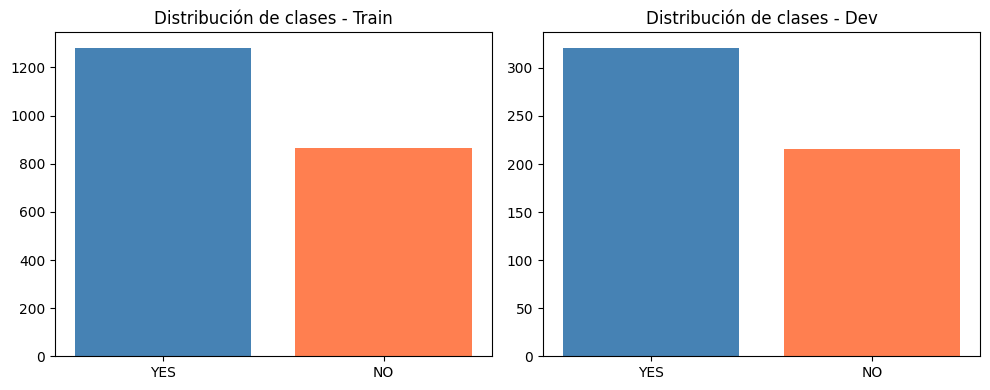

Class balance (train): {1: 0.5973904939422181, 0: 0.4026095060577819}


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (df, title) in zip(axes, [(train_df, 'Train'), (dev_df, 'Dev')]):
    counts = df['label'].value_counts()
    ax.bar([label_map_inverse[k] for k in counts.index], counts.values, color=['steelblue', 'coral'])
    ax.set_title(f'Distribución de clases - {title}')
plt.tight_layout(); plt.show()
print('Class balance (train):', train_df['label'].value_counts(normalize=True).to_dict())

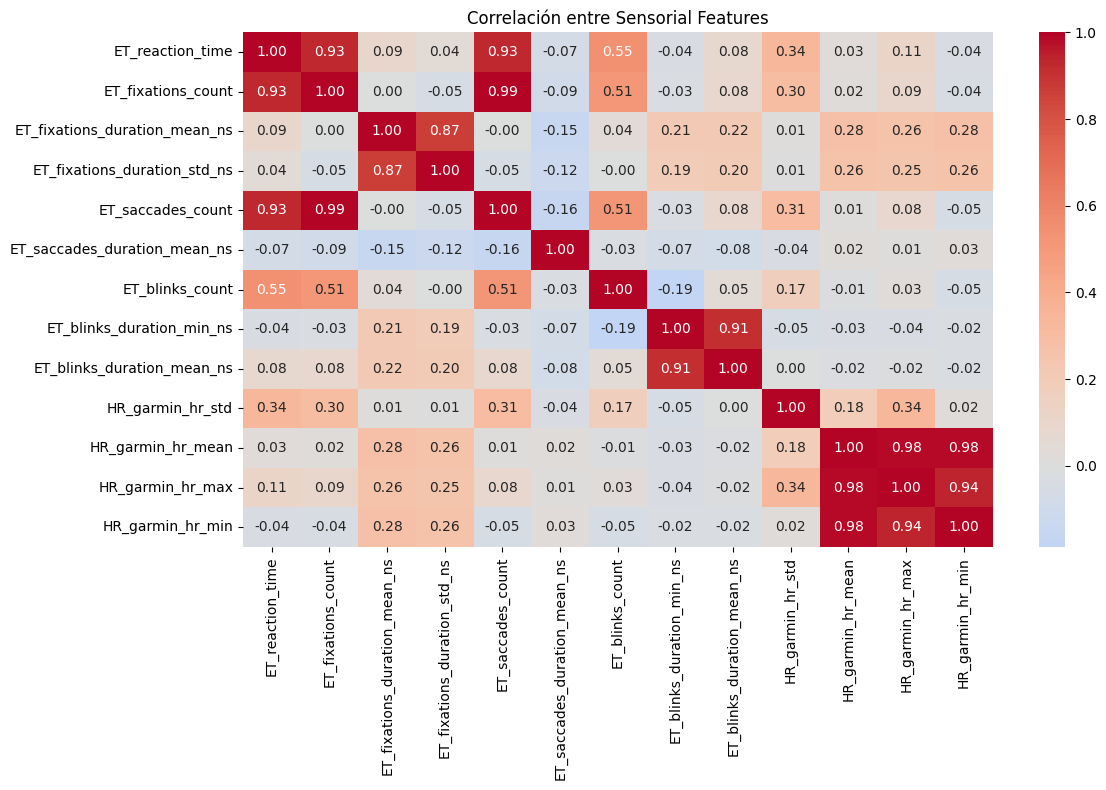

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df[FEATURE_COLS].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlación entre Sensorial Features')
plt.tight_layout(); plt.show()

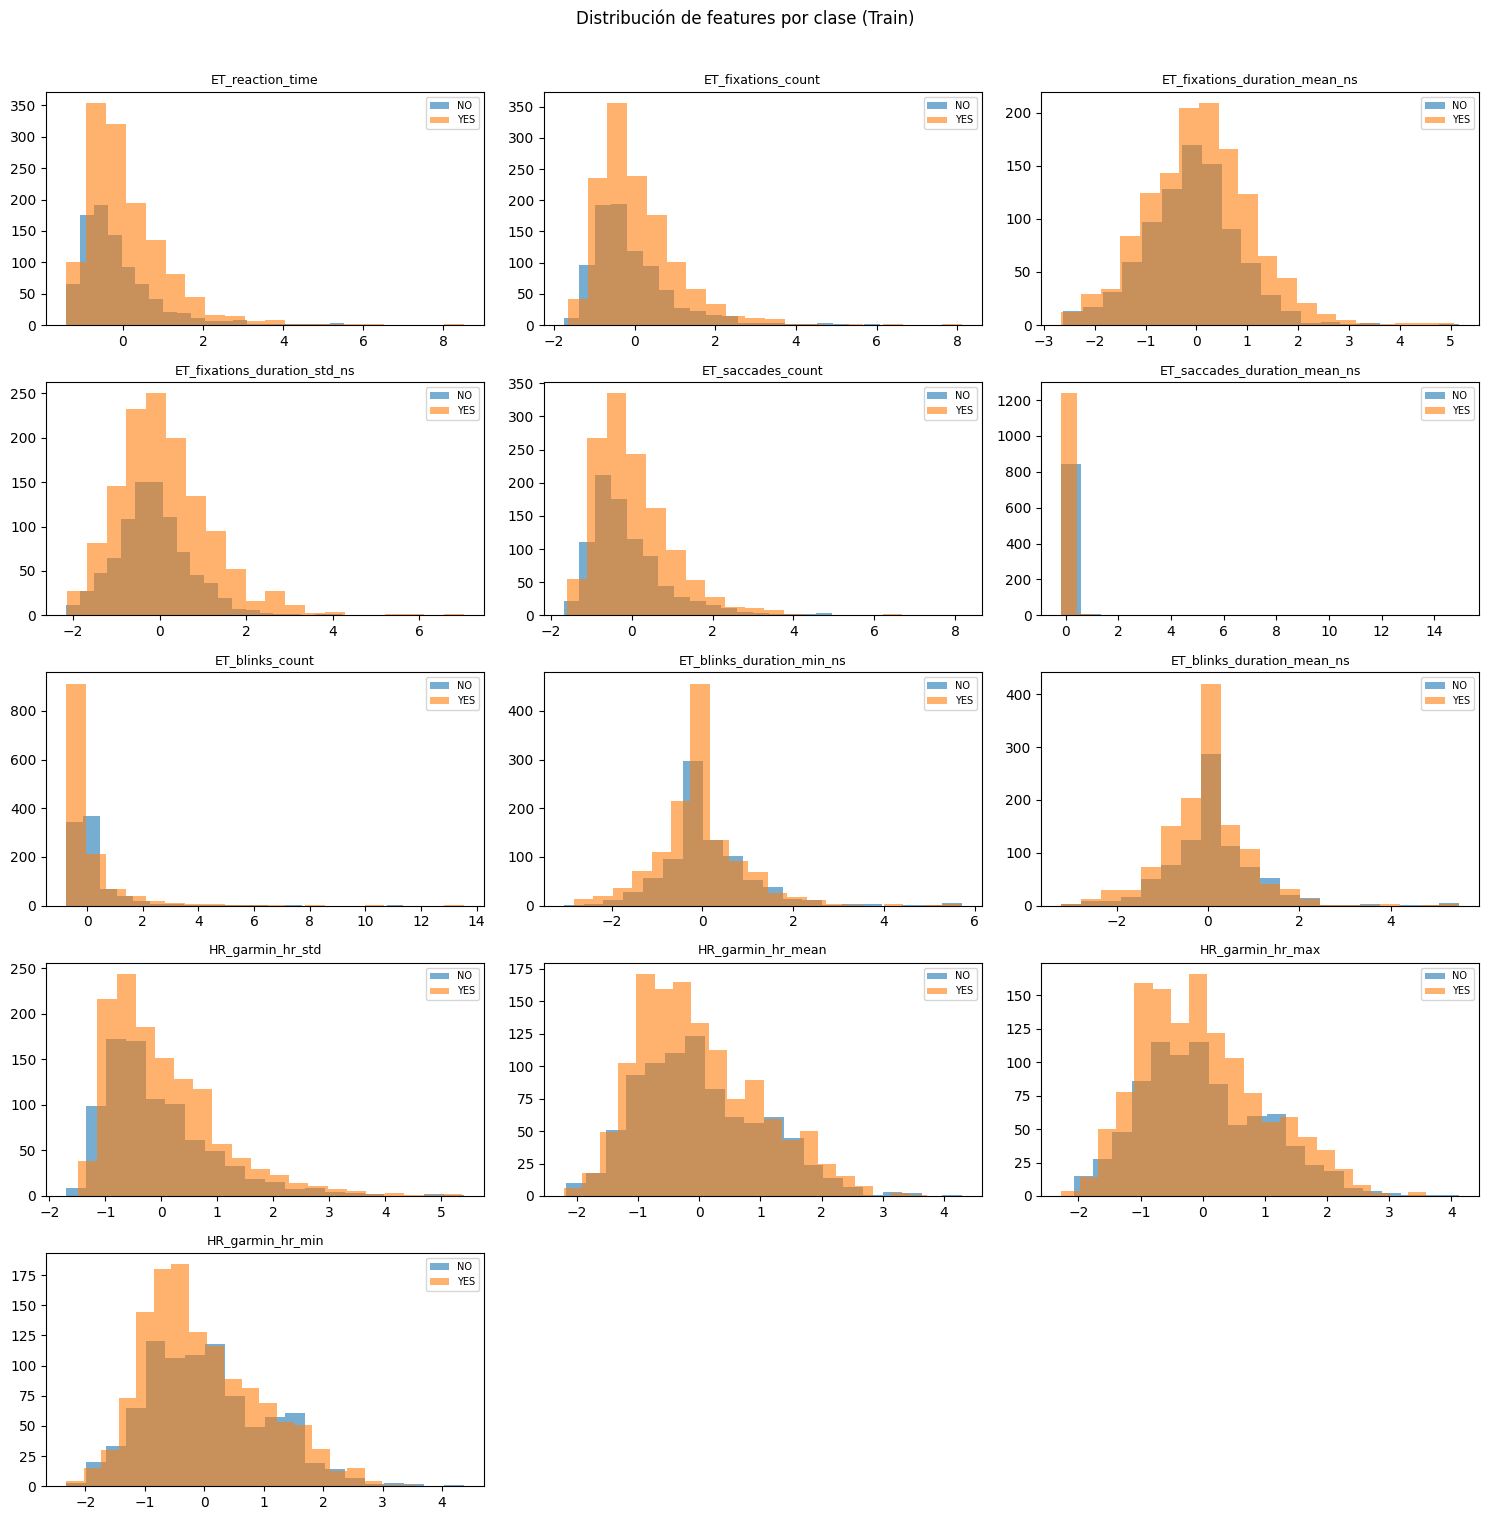

In [6]:
n_cols = 3
n_rows = (len(FEATURE_COLS) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()
for i, col in enumerate(FEATURE_COLS):
    for lv, ln in label_map_inverse.items():
        axes[i].hist(train_df[train_df['label'] == lv][col], bins=20, alpha=0.6, label=ln)
    axes[i].set_title(col, fontsize=9); axes[i].legend(fontsize=7)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.suptitle('Distribución de features por clase (Train)', y=1.01)
plt.tight_layout(); plt.show()

## Dataset y DataLoader

In [7]:
class SensorialDataset(Dataset):
    def __init__(self, df, feature_cols, has_labels=True):
        self.X = torch.tensor(df[feature_cols].fillna(0).values, dtype=torch.float32)
        self.has_labels = has_labels
        if has_labels:
            self.y = torch.tensor(df['label'].values, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx]) if self.has_labels else self.X[idx]

BATCH_SIZE = 32
train_loader = DataLoader(SensorialDataset(train_df, FEATURE_COLS),       batch_size=BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(SensorialDataset(dev_df,   FEATURE_COLS),       batch_size=BATCH_SIZE)
test_loader  = DataLoader(SensorialDataset(test_df,  FEATURE_COLS, False), batch_size=BATCH_SIZE)
print(f'Batches - Train: {len(train_loader)} | Dev: {len(dev_loader)} | Test: {len(test_loader)}')

Batches - Train: 68 | Dev: 17 | Test: 22


## Arquitecturas

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.3, use_bn=True):
        super().__init__()
        layers, prev = [], input_dim
        for h in hidden_dims:
            layers += [nn.Linear(prev, h)]
            if use_bn: layers += [nn.BatchNorm1d(h)]
            layers += [nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x).squeeze(-1)


class ResBlock(nn.Module):
    def __init__(self, dim, dropout=0.3):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim), nn.BatchNorm1d(dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(dim, dim), nn.BatchNorm1d(dim))
    def forward(self, x): return F.relu(x + self.block(x))


class ResMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_blocks, dropout=0.3):
        super().__init__()
        self.proj   = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.Sequential(*[ResBlock(hidden_dim, dropout) for _ in range(n_blocks)])
        self.head   = nn.Linear(hidden_dim, 1)
    def forward(self, x): return self.head(self.blocks(F.relu(self.proj(x)))).squeeze(-1)

## Entrenamiento y evaluación

In [9]:
def compute_pos_weight(df):
    c = df['label'].value_counts()
    return torch.tensor([c.get(0, 1) / c.get(1, 1)], dtype=torch.float32).to(DEVICE)

def train_epoch(model, loader, opt, sched, criterion, use_onecycle):
    model.train(); total = 0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        if use_onecycle: sched.step()
        total += loss.item()
    return total / len(loader)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    logits, labels = [], []
    for X, y in loader:
        logits.append(model(X.to(DEVICE)).cpu()); labels.append(y)
    probs = torch.sigmoid(torch.cat(logits)).numpy()
    labs  = torch.cat(labels).numpy()
    preds = (probs >= 0.5).astype(int)
    f1  = precision_recall_fscore_support(labs, preds, average='binary', zero_division=0)[2]
    return {'f1': f1, 'acc': accuracy_score(labs, preds)}

def train_model(model, config, train_loader, dev_loader, verbose=True):
    model.to(DEVICE)
    criterion = nn.BCEWithLogitsLoss(pos_weight=compute_pos_weight(train_df))
    opt = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    use_oc = config['scheduler'] == 'onecycle'
    sched  = (OneCycleLR(opt, max_lr=config['lr'], steps_per_epoch=len(train_loader),
                         epochs=config['epochs'], pct_start=0.3)
              if use_oc else CosineAnnealingLR(opt, T_max=config['epochs'], eta_min=1e-6))
    best_f1, best_state = 0.0, None
    history = {'train_loss': [], 'dev_f1': [], 'dev_acc': []}
    for epoch in range(1, config['epochs'] + 1):
        tl = train_epoch(model, train_loader, opt, sched, criterion, use_oc)
        if not use_oc: sched.step()
        dm = evaluate(model, dev_loader)
        history['train_loss'].append(tl); history['dev_f1'].append(dm['f1']); history['dev_acc'].append(dm['acc'])
        if dm['f1'] > best_f1:
            best_f1 = dm['f1']
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
        if verbose and epoch % 10 == 0:
            print(f'  E{epoch:3d}/{config["epochs"]} | Loss: {tl:.4f} | DevF1: {dm["f1"]:.4f} | DevAcc: {dm["acc"]:.4f}')
    model.load_state_dict(best_state)
    return model, history, best_f1

## Exploración de arquitecturas

In [10]:
experiments = [
    ('MLP_small_onecycle',
     MLP(INPUT_DIM, [64, 32], 0.3),
     {'lr': 1e-3, 'weight_decay': 1e-4, 'epochs': 100, 'scheduler': 'onecycle'}),
    ('MLP_medium_onecycle',
     MLP(INPUT_DIM, [128, 64, 32], 0.3),
     {'lr': 1e-3, 'weight_decay': 1e-4, 'epochs': 100, 'scheduler': 'onecycle'}),
    ('MLP_large_onecycle',
     MLP(INPUT_DIM, [256, 128, 64, 32], 0.4),
     {'lr': 5e-4, 'weight_decay': 1e-4, 'epochs': 150, 'scheduler': 'onecycle'}),
    ('MLP_deep_cosine',
     MLP(INPUT_DIM, [128, 64, 64, 32], 0.2),
     {'lr': 1e-3, 'weight_decay': 1e-3, 'epochs': 150, 'scheduler': 'cosine'}),
    ('ResMLP_2blocks_onecycle',
     ResMLP(INPUT_DIM, 64, 2, 0.3),
     {'lr': 1e-3, 'weight_decay': 1e-4, 'epochs': 100, 'scheduler': 'onecycle'}),
    ('ResMLP_4blocks_cosine',
     ResMLP(INPUT_DIM, 128, 4, 0.3),
     {'lr': 5e-4, 'weight_decay': 1e-4, 'epochs': 150, 'scheduler': 'cosine'}),
    ('MLP_high_lr_cosine',
     MLP(INPUT_DIM, [64, 64], 0.2),
     {'lr': 3e-3, 'weight_decay': 1e-3, 'epochs': 100, 'scheduler': 'cosine'}),
]
print(f'{len(experiments)} experimentos definidos.')

7 experimentos definidos.


In [11]:
results = []
for exp_name, model, config in experiments:
    print(f'\n{"="*55}\n  {exp_name}\n{"="*55}')
    torch.manual_seed(SEED)
    m, history, best_f1 = train_model(model, config, train_loader, dev_loader)
    results.append({'name': exp_name, 'model': m, 'history': history,
                    'best_dev_f1': best_f1, 'config': config})
    print(f'  >>> Best Dev F1: {best_f1:.4f}')


  MLP_small_onecycle


  E 10/100 | Loss: 0.5533 | DevF1: 0.6233 | DevAcc: 0.5791


  E 20/100 | Loss: 0.5415 | DevF1: 0.5876 | DevAcc: 0.5661


  E 30/100 | Loss: 0.5416 | DevF1: 0.6120 | DevAcc: 0.5773


  E 40/100 | Loss: 0.5405 | DevF1: 0.6548 | DevAcc: 0.6034


  E 50/100 | Loss: 0.5316 | DevF1: 0.6494 | DevAcc: 0.5978


  E 60/100 | Loss: 0.5337 | DevF1: 0.6506 | DevAcc: 0.5940


  E 70/100 | Loss: 0.5263 | DevF1: 0.6185 | DevAcc: 0.5773


  E 80/100 | Loss: 0.5269 | DevF1: 0.6187 | DevAcc: 0.5754


  E 90/100 | Loss: 0.5257 | DevF1: 0.6267 | DevAcc: 0.5829


  E100/100 | Loss: 0.5229 | DevF1: 0.6102 | DevAcc: 0.5717
  >>> Best Dev F1: 0.6779

  MLP_medium_onecycle


  E 10/100 | Loss: 0.5494 | DevF1: 0.6316 | DevAcc: 0.5829


  E 20/100 | Loss: 0.5399 | DevF1: 0.5714 | DevAcc: 0.5642


  E 30/100 | Loss: 0.5381 | DevF1: 0.5983 | DevAcc: 0.5698


  E 40/100 | Loss: 0.5352 | DevF1: 0.6193 | DevAcc: 0.5810


  E 50/100 | Loss: 0.5245 | DevF1: 0.6143 | DevAcc: 0.5791


  E 60/100 | Loss: 0.5304 | DevF1: 0.6321 | DevAcc: 0.5903


  E 70/100 | Loss: 0.5176 | DevF1: 0.6133 | DevAcc: 0.5773


  E 80/100 | Loss: 0.5219 | DevF1: 0.6084 | DevAcc: 0.5829


  E 90/100 | Loss: 0.5167 | DevF1: 0.6330 | DevAcc: 0.5940


  E100/100 | Loss: 0.5122 | DevF1: 0.6098 | DevAcc: 0.5829
  >>> Best Dev F1: 0.7097

  MLP_large_onecycle


  E 10/150 | Loss: 0.5727 | DevF1: 0.3468 | DevAcc: 0.4879


  E 20/150 | Loss: 0.5517 | DevF1: 0.4703 | DevAcc: 0.5345


  E 30/150 | Loss: 0.5456 | DevF1: 0.5451 | DevAcc: 0.5493


  E 40/150 | Loss: 0.5434 | DevF1: 0.6011 | DevAcc: 0.5773


  E 50/150 | Loss: 0.5322 | DevF1: 0.5993 | DevAcc: 0.5717


  E 60/150 | Loss: 0.5347 | DevF1: 0.6199 | DevAcc: 0.5866


  E 70/150 | Loss: 0.5275 | DevF1: 0.5673 | DevAcc: 0.5568


  E 80/150 | Loss: 0.5290 | DevF1: 0.5954 | DevAcc: 0.5773


  E 90/150 | Loss: 0.5278 | DevF1: 0.6098 | DevAcc: 0.5829


  E100/150 | Loss: 0.5284 | DevF1: 0.5855 | DevAcc: 0.5754


  E110/150 | Loss: 0.5145 | DevF1: 0.5972 | DevAcc: 0.5754


  E120/150 | Loss: 0.5181 | DevF1: 0.5939 | DevAcc: 0.5773


  E130/150 | Loss: 0.5194 | DevF1: 0.5986 | DevAcc: 0.5754


  E140/150 | Loss: 0.5175 | DevF1: 0.5756 | DevAcc: 0.5661


  E150/150 | Loss: 0.5294 | DevF1: 0.6205 | DevAcc: 0.5922
  >>> Best Dev F1: 0.6523

  MLP_deep_cosine


  E 10/150 | Loss: 0.5369 | DevF1: 0.6524 | DevAcc: 0.6071


  E 20/150 | Loss: 0.5267 | DevF1: 0.5751 | DevAcc: 0.5736


  E 30/150 | Loss: 0.5196 | DevF1: 0.6241 | DevAcc: 0.5940


  E 40/150 | Loss: 0.5219 | DevF1: 0.5993 | DevAcc: 0.5791


  E 50/150 | Loss: 0.5102 | DevF1: 0.6021 | DevAcc: 0.5791


  E 60/150 | Loss: 0.5137 | DevF1: 0.6117 | DevAcc: 0.5791


  E 70/150 | Loss: 0.5022 | DevF1: 0.6183 | DevAcc: 0.5885


  E 80/150 | Loss: 0.5050 | DevF1: 0.5755 | DevAcc: 0.5605


  E 90/150 | Loss: 0.4987 | DevF1: 0.6081 | DevAcc: 0.5847


  E100/150 | Loss: 0.4943 | DevF1: 0.5704 | DevAcc: 0.5512


  E110/150 | Loss: 0.4855 | DevF1: 0.5989 | DevAcc: 0.5736


  E120/150 | Loss: 0.4892 | DevF1: 0.5857 | DevAcc: 0.5680


  E130/150 | Loss: 0.4839 | DevF1: 0.5481 | DevAcc: 0.5456


  E140/150 | Loss: 0.4813 | DevF1: 0.5492 | DevAcc: 0.5568


  E150/150 | Loss: 0.4946 | DevF1: 0.5918 | DevAcc: 0.5736
  >>> Best Dev F1: 0.6739

  ResMLP_2blocks_onecycle


  E 10/100 | Loss: 0.5435 | DevF1: 0.5683 | DevAcc: 0.5531


  E 20/100 | Loss: 0.5265 | DevF1: 0.5770 | DevAcc: 0.5549


  E 30/100 | Loss: 0.5166 | DevF1: 0.6235 | DevAcc: 0.5885


  E 40/100 | Loss: 0.5105 | DevF1: 0.6481 | DevAcc: 0.5996


  E 50/100 | Loss: 0.4847 | DevF1: 0.5662 | DevAcc: 0.5549


  E 60/100 | Loss: 0.4856 | DevF1: 0.6388 | DevAcc: 0.5978


  E 70/100 | Loss: 0.4553 | DevF1: 0.6547 | DevAcc: 0.6071


  E 80/100 | Loss: 0.4507 | DevF1: 0.5796 | DevAcc: 0.5624


  E 90/100 | Loss: 0.4364 | DevF1: 0.6162 | DevAcc: 0.5754


  E100/100 | Loss: 0.4254 | DevF1: 0.5959 | DevAcc: 0.5605
  >>> Best Dev F1: 0.6856

  ResMLP_4blocks_cosine


  E 10/150 | Loss: 0.5352 | DevF1: 0.5771 | DevAcc: 0.5605


  E 20/150 | Loss: 0.5186 | DevF1: 0.6015 | DevAcc: 0.5978


  E 30/150 | Loss: 0.5014 | DevF1: 0.6028 | DevAcc: 0.5754


  E 40/150 | Loss: 0.4931 | DevF1: 0.6084 | DevAcc: 0.5829


  E 50/150 | Loss: 0.4731 | DevF1: 0.5683 | DevAcc: 0.5587


  E 60/150 | Loss: 0.4671 | DevF1: 0.6051 | DevAcc: 0.5698


  E 70/150 | Loss: 0.4328 | DevF1: 0.6367 | DevAcc: 0.5791


  E 80/150 | Loss: 0.4452 | DevF1: 0.6149 | DevAcc: 0.5754


  E 90/150 | Loss: 0.4128 | DevF1: 0.5966 | DevAcc: 0.5568


  E100/150 | Loss: 0.4145 | DevF1: 0.5949 | DevAcc: 0.5587


  E110/150 | Loss: 0.3843 | DevF1: 0.6182 | DevAcc: 0.5698


  E120/150 | Loss: 0.3821 | DevF1: 0.6374 | DevAcc: 0.5847


  E130/150 | Loss: 0.3779 | DevF1: 0.5808 | DevAcc: 0.5456


  E140/150 | Loss: 0.3607 | DevF1: 0.6084 | DevAcc: 0.5661


  E150/150 | Loss: 0.3795 | DevF1: 0.6367 | DevAcc: 0.5791
  >>> Best Dev F1: 0.6973

  MLP_high_lr_cosine


  E 10/100 | Loss: 0.5335 | DevF1: 0.6199 | DevAcc: 0.5866


  E 20/100 | Loss: 0.5246 | DevF1: 0.5522 | DevAcc: 0.5531


  E 30/100 | Loss: 0.5231 | DevF1: 0.6162 | DevAcc: 0.5754


  E 40/100 | Loss: 0.5252 | DevF1: 0.6437 | DevAcc: 0.5959


  E 50/100 | Loss: 0.5157 | DevF1: 0.6105 | DevAcc: 0.5698


  E 60/100 | Loss: 0.5128 | DevF1: 0.6393 | DevAcc: 0.5903


  E 70/100 | Loss: 0.4972 | DevF1: 0.6112 | DevAcc: 0.5736


  E 80/100 | Loss: 0.5043 | DevF1: 0.6000 | DevAcc: 0.5680


  E 90/100 | Loss: 0.5044 | DevF1: 0.6338 | DevAcc: 0.5847


  E100/100 | Loss: 0.4927 | DevF1: 0.6031 | DevAcc: 0.5661
  >>> Best Dev F1: 0.6928


In [12]:
res_df = pd.DataFrame([{'Exp': r['name'], 'DevF1': r['best_dev_f1'],
                        'Sched': r['config']['scheduler'], 'LR': r['config']['lr']}
                       for r in results]).sort_values('DevF1', ascending=False)
print(res_df.to_string(index=False))

                    Exp    DevF1    Sched     LR
    MLP_medium_onecycle 0.709677 onecycle 0.0010
  ResMLP_4blocks_cosine 0.697329   cosine 0.0005
     MLP_high_lr_cosine 0.692771   cosine 0.0030
ResMLP_2blocks_onecycle 0.685624 onecycle 0.0010
     MLP_small_onecycle 0.677914 onecycle 0.0010
        MLP_deep_cosine 0.673947   cosine 0.0010
     MLP_large_onecycle 0.652318 onecycle 0.0005


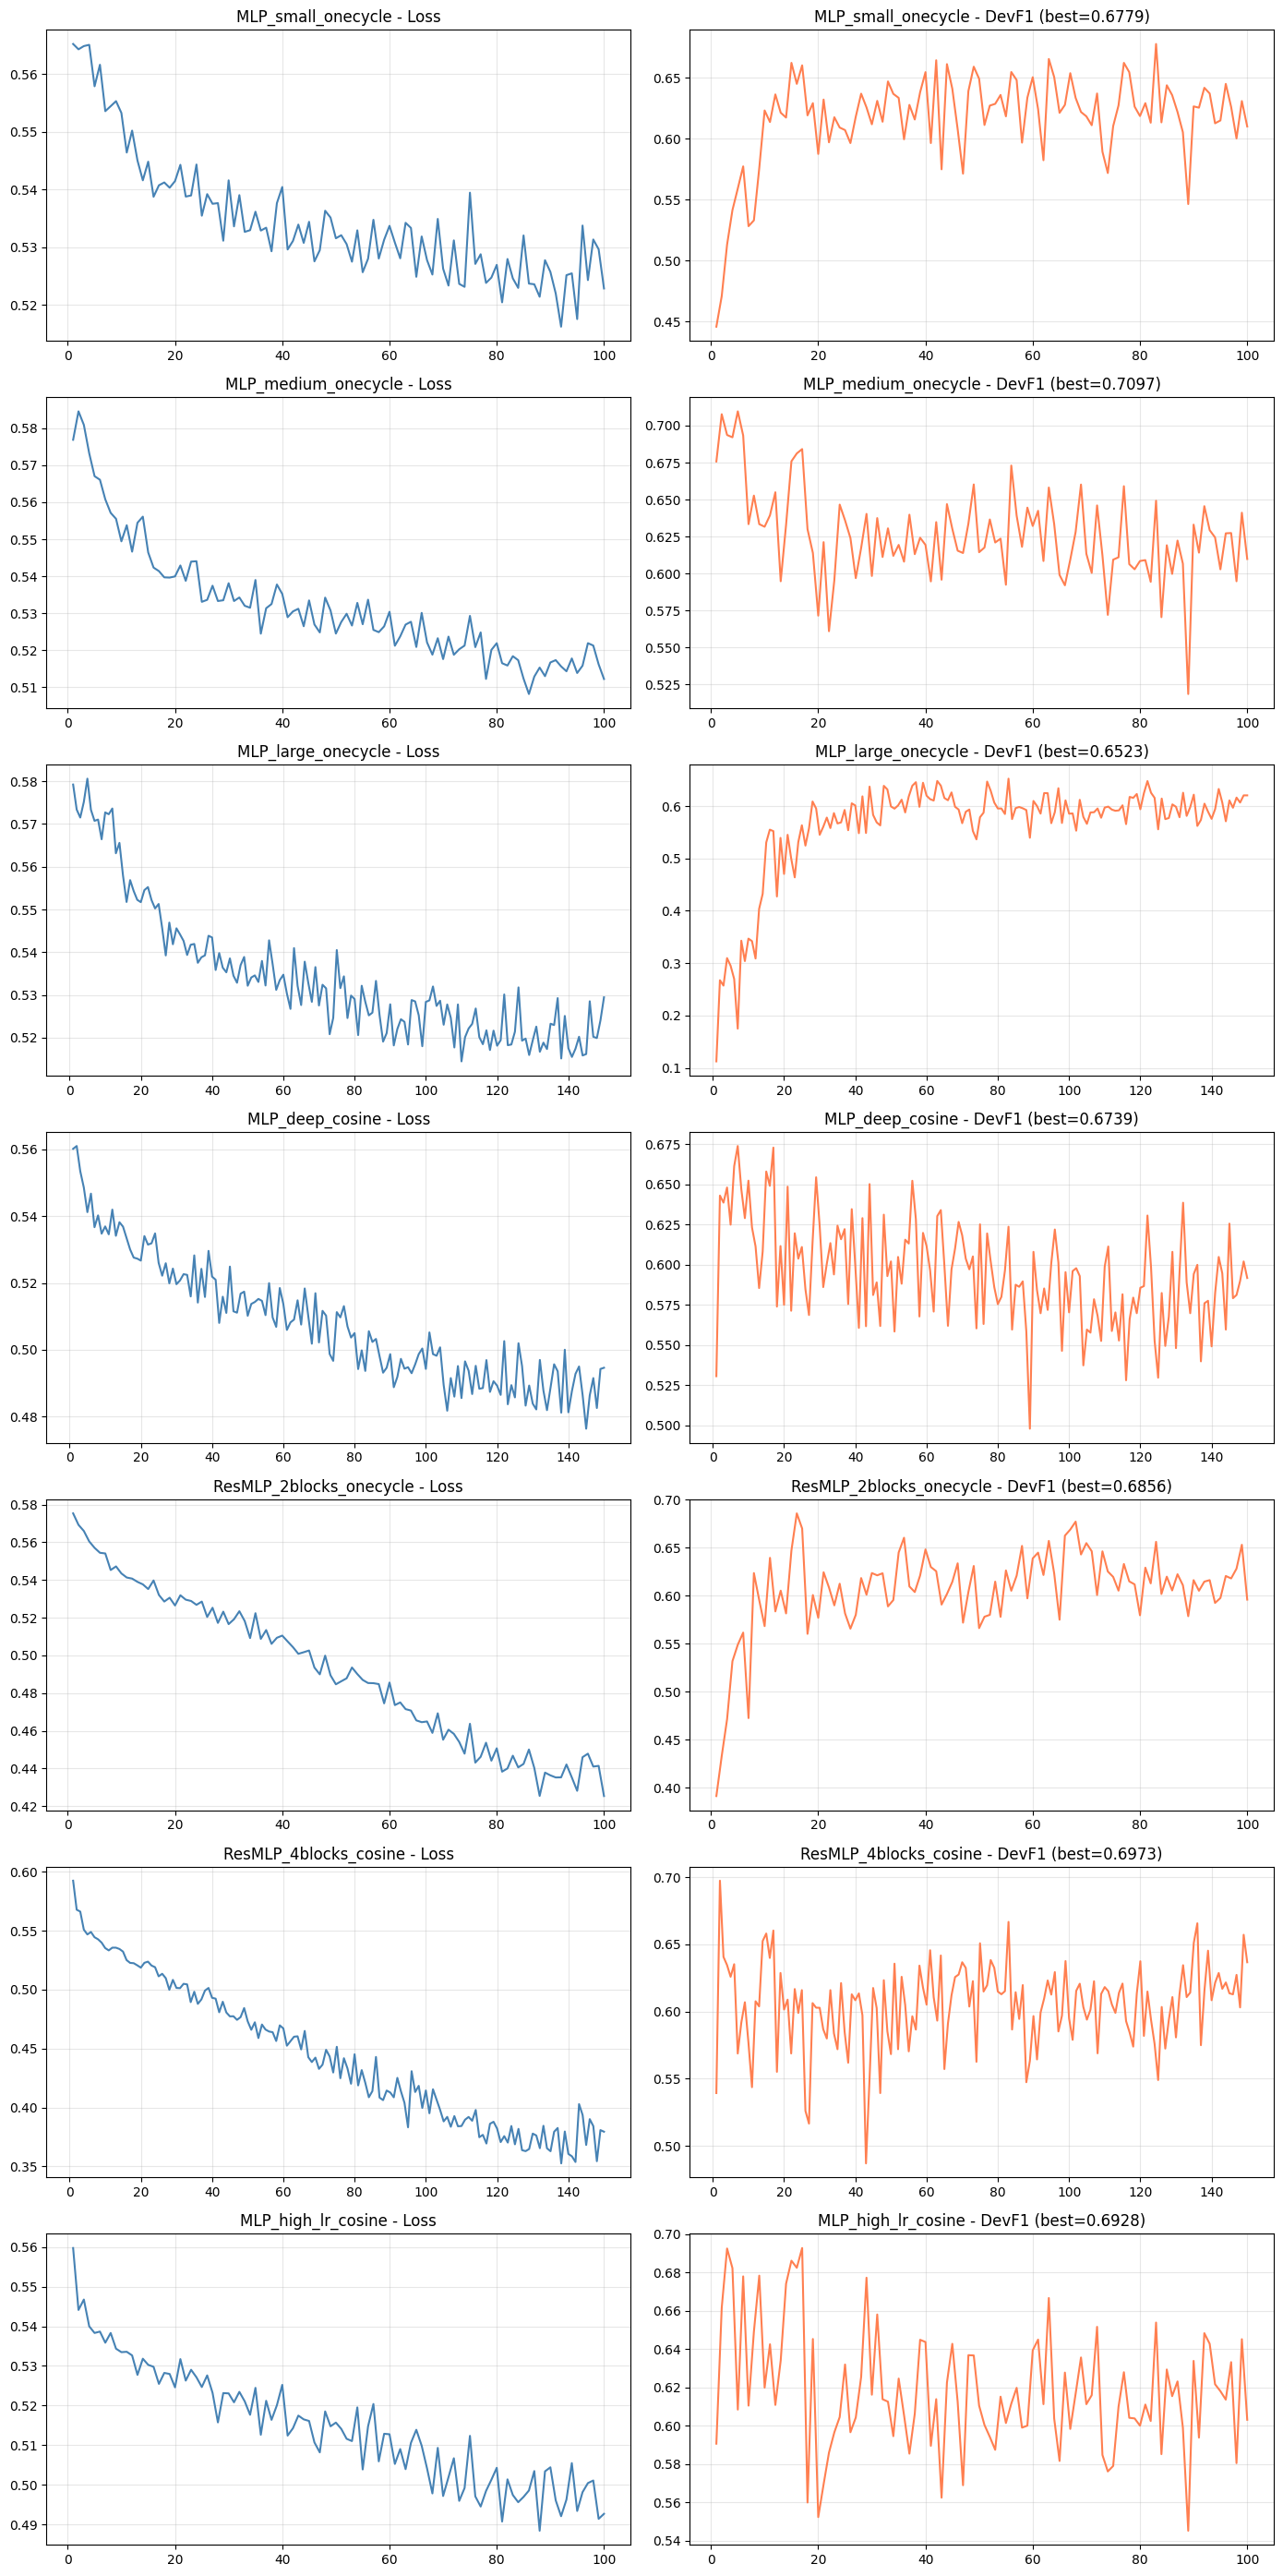

In [13]:
fig, axes = plt.subplots(len(results), 2, figsize=(14, 4 * len(results)))
if len(results) == 1: axes = [axes]
for i, r in enumerate(results):
    h  = r['history']
    ep = range(1, len(h['train_loss']) + 1)
    axes[i][0].plot(ep, h['train_loss'], color='steelblue')
    axes[i][0].set_title(f'{r["name"]} - Loss'); axes[i][0].grid(alpha=0.3)
    axes[i][1].plot(ep, h['dev_f1'], color='coral')
    axes[i][1].set_title(f'{r["name"]} - DevF1 (best={r["best_dev_f1"]:.4f})')
    axes[i][1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

## Mejor Modelo → Threshold Óptimo en DEV

In [14]:
best_result = max(results, key=lambda r: r['best_dev_f1'])
best_model  = best_result['model']
print(f'✅ Mejor modelo: {best_result["name"]}  (Dev F1 = {best_result["best_dev_f1"]:.4f})')

✅ Mejor modelo: MLP_medium_onecycle  (Dev F1 = 0.7097)


In [15]:
best_model.eval()
all_logits, all_labels = [], []
with torch.no_grad():
    for X, y in dev_loader:
        all_logits.append(best_model(X.to(DEVICE)).cpu()); all_labels.append(y)

dev_logits  = torch.cat(all_logits)
y_probs_dev = torch.sigmoid(dev_logits).numpy()
y_true_dev  = torch.cat(all_labels).numpy().astype(int)

fpr, tpr, _ = roc_curve(y_true_dev, y_probs_dev)

precisions, recalls, thresholds = precision_recall_curve(y_true_dev, y_probs_dev)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

roc_auc = auc(fpr, tpr)

print(f'AUC (DEV): {roc_auc:.4f}')
print(f'Mejor Threshold (DEV): {optimal_threshold:.4f}')
print(f'TPR en mejor threshold: {tpr[optimal_idx]:.4f}')
print(f'FPR en mejor threshold: {fpr[optimal_idx]:.4f}')

dev_preds_optimal = (y_probs_dev >= optimal_threshold).astype(int)
precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
    y_true_dev, dev_preds_optimal, average='binary', zero_division=0)
acc_opt = accuracy_score(y_true_dev, dev_preds_optimal)

print(f'\nMétricas en DEV con threshold óptimo ({optimal_threshold:.4f}):')
print(f'  Accuracy:  {acc_opt:.4f}')
print(f'  Precision: {precision_opt:.4f}')
print(f'  Recall:    {recall_opt:.4f}')
print(f'  F1-Score:  {f1_opt:.4f}')

AUC (DEV): 0.5920
Mejor Threshold (DEV): 0.3741
TPR en mejor threshold: 0.0093
FPR en mejor threshold: 0.0000

Métricas en DEV con threshold óptimo (0.3741):
  Accuracy:  0.6015
  Precision: 0.6000
  Recall:    1.0000
  F1-Score:  0.7500


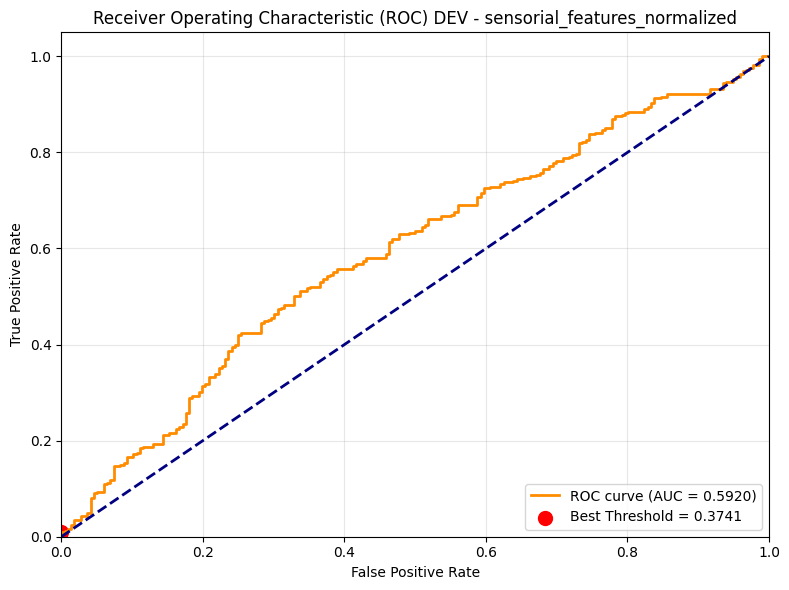

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) DEV - {TEXT_COLUMN}')
plt.legend(loc='lower right'); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

In [17]:
print('Classification Report (DEV, threshold óptimo):')
print(classification_report(y_true_dev, dev_preds_optimal, target_names=list(label_map_inverse.values())))

Classification Report (DEV, threshold óptimo):
              precision    recall  f1-score   support

          NO       1.00      0.01      0.02       216
         YES       0.60      1.00      0.75       321

    accuracy                           0.60       537
   macro avg       0.80      0.50      0.38       537
weighted avg       0.76      0.60      0.46       537



## Inferencia y guardado

In [ ]:
@torch.no_grad()
def get_probs(model, loader, has_labels=True):
    """Devuelve P(YES) para todos los ejemplos del loader."""
    model.eval()
    all_probs = []
    for batch in loader:
        X = batch[0] if has_labels else batch
        all_probs.extend(torch.sigmoid(model(X.to(DEVICE))).cpu().numpy().tolist())
    return np.array(all_probs)


def save_probs_json(ids, probs, split_name, labels=None):
    """
    Guarda un JSON con formato:
      [{"id": "111945", "prob_YES": 0.734, "label": "YES"}, ...]
    El campo 'label' solo se incluye en dev (cuando labels != None).
    """
    records = []
    for i, (id_exist, prob) in enumerate(zip(ids, probs)):
        rec = {'id': str(id_exist), 'prob_YES': round(float(prob), 6)}
        if labels is not None:
            rec['label'] = label_map_inverse[int(labels[i])]
        records.append(rec)
    path = os.path.join(PREDICTIONS_DIR, f'{GROUP_ID}_{MODEL_ID}_probs_{split_name}.json')
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(records, f, ensure_ascii=False, indent=2)
    print(f'  ✅ {split_name:5s} ({len(records):5d} items) → {path}')


test_probs = get_probs(best_model, test_loader, has_labels=False)
test_preds = (test_probs >= optimal_threshold).astype(int)
print(f'Test → YES: {test_preds.sum()} | NO: {(test_preds == 0).sum()}\n')

print('Guardando JSONs de probabilidades (para el ensamble)...')
save_probs_json(dev_df['id_EXIST'].values,  y_probs_dev, 'dev',  labels=dev_df['label'].values)
save_probs_json(test_df['id_EXIST'].values, test_probs,  'test')

Test → YES: 680 | NO: 7

Guardando JSONs de probabilidades (para el ensamble)...
  ✅ dev   (  537 items) → ../predictions/BeingChillingWeWillWin_MLPsensorial_probs_dev.json
  ✅ test  (  687 items) → ../predictions/BeingChillingWeWillWin_MLPsensorial_probs_test.json


In [19]:
test_preds_for_submission = []
for idx, (id_exist, pred) in enumerate(zip(test_df['id_EXIST'].values, test_preds)):
    test_preds_for_submission.append({
        'test_case': 'EXIST2025',
        'id': str(id_exist),
        'value': label_map_inverse[pred]
    })

test_preds_df = pd.DataFrame(test_preds_for_submission)
output_path   = os.path.join(PREDICTIONS_DIR, f'{GROUP_ID}_{MODEL_ID}.json')

with open(output_path, 'w', encoding='utf-8') as output_file:
    output_file.write(test_preds_df.to_json(orient='records'))

print(f'Predicciones de submission guardadas en: {output_path}')
print(test_preds_df.head(10))

Predicciones de submission guardadas en: ../predictions/BeingChillingWeWillWin_MLPsensorial.json
   test_case      id value
0  EXIST2025  110887   YES
1  EXIST2025  110444   YES
2  EXIST2025  110460   YES
3  EXIST2025  110012   YES
4  EXIST2025  111106    NO
5  EXIST2025  111207   YES
6  EXIST2025  110402   YES
7  EXIST2025  111580   YES
8  EXIST2025  111303   YES
9  EXIST2025  111604   YES


## Guardar el mejor modelo

In [20]:
model_save_path = os.path.join(WEIGHTS_DIR, f'{GROUP_ID}_{MODEL_ID}_model.pt')
torch.save({
    'model_state_dict':  best_model.state_dict(),
    'model_name':        best_result['name'],
    'config':            best_result['config'],
    'optimal_threshold': optimal_threshold,
    'best_dev_f1':       best_result['best_dev_f1'],
    'feature_cols':      FEATURE_COLS
}, model_save_path)

print(f'Modelo guardado en: {model_save_path}')
print(f'\n📋 Resumen final:')
print(f'  Mejor modelo:     {best_result["name"]}')
print(f'  Dev F1 (0.5):     {best_result["best_dev_f1"]:.4f}')
print(f'  Dev F1 (óptimo):  {f1_opt:.4f}')
print(f'  Threshold óptimo: {optimal_threshold:.4f}')
print(f'  AUC DEV:          {roc_auc:.4f}')
print(f'\n📁 Archivos en {PREDICTIONS_DIR}/:')
for fname in sorted(os.listdir(PREDICTIONS_DIR)):
    print(f'  {fname}')

Modelo guardado en: ../weigths/BeingChillingWeWillWin_MLPsensorial_model.pt

📋 Resumen final:
  Mejor modelo:     MLP_medium_onecycle
  Dev F1 (0.5):     0.7097
  Dev F1 (óptimo):  0.7500
  Threshold óptimo: 0.3741
  AUC DEV:          0.5920

📁 Archivos en ../predictions/:
  BeingChillingWeWillWin_MLPsensorial.json
  BeingChillingWeWillWin_MLPsensorial_probs_dev.json
  BeingChillingWeWillWin_MLPsensorial_probs_test.json
